# Numerical Gaussian curvature with Pytorch
adapted from https://github.com/jamesgolden1/bias_free_denoising/blob/manifold_metric/curvature/hyperboloid_single_sheet_curvature_compare.ipynb

In order to validate measuring curvature numerically with Pytorch, the curvature for a single-sheeted hyperboloid is computed and compared with the theoretical values. The canonical example for curvature is a sphere, but in that case the curvarture values are the same at every point. This hyperboloid curvature is different at every point.

## One-sheeted hyperboloid
https://mathworld.wolfram.com/One-SheetedHyperboloid.html

![](https://mathworld.wolfram.com/images/eps-gif/Hyperboloid1Sheeted1_500.gif) 

When oriented along the z-axis, the one-sheeted circular hyperboloid with skirt radius $a$ has a Cartesian equation

$$\frac{x^2}{a^2} + \frac{y^2}{a^2} - \frac{z^2}{c^2} = 1$$

and a parametric equations
$$
\begin{align}
x &= a \sqrt{1 + u^2} \cos v \\
y &= a \sqrt{1 + u^2} \sin v \\
z &= c * u
\end{align}
$$

Therefore, $u = \frac{z}{c}$ and

$$
\begin{align}
z &= \sqrt{-c^2 \left(1 - \left(\frac{x^2}{a^2} + \frac{y^2}{a^2}\right)\right)}\\
&= \sqrt{c^2 \left(\frac{x^2}{a^2} + \frac{y^2}{a^2} - 1\right)}
\end{align}
$$


The Gaussian curvature at each point is:

$$K(u,v) = -\frac{c^{2}}{\left[c^{2} + \left(a^{2} + c^{2}\right)u^{2}\right]^{2}}$$

The mean curvature at each point is:

$$H(u,v) = \frac{c^{2} \left[ a^{2} \left(u^{2} - 1\right) + c^{2}\left(u^{2}+1\right) \right]}{2a \left[c^{2} + \left(a^{2} + c^{2}\right) u^{2} \right]^{3/2}}$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import proplot as plot
import torch
import torch.nn as nn
from tqdm import tqdm

current_path = !pwd # TODO: Will this change if someone runs the notebook from elsewhere, or changes the cwd in the notebook?
parent_path = os.path.dirname(current_path[0])
if parent_path not in sys.path: sys.path.append(parent_path)

import utils.model_handling as model_funcs
import utils.principal_curvature as curv_funcs

# Utility functions

In [2]:
def hyperboloid_eq(x_vals, y_vals, a, c):
    z_sq = c**2 * (x_vals**2 / a**2 + y_vals**2 / a**2 - 1)
    if type(x_vals) == type(torch.Tensor()):
        return torch.sqrt_(z_sq)
    else:
        return np.sqrt(z_sq)
    
def hyperboloid_mesh(a, c, step_size, num_points):
    pt_range = (num_points - 1) * step_size
    start_pt = 0 - pt_range / 2
    end_pt = 0 + pt_range / 2
    x_pts = np.linspace(start_pt, end_pt, num_points)
    y_pts = np.linspace(start_pt, end_pt, num_points)
    x_mesh, y_mesh = np.meshgrid(x_pts, y_pts)
    return x_mesh, y_mesh

def hyperboloid(a, c, step_size, num_points):
    """generate single sheet hyperboloid"""
    x_mesh, y_mesh = hyperboloid_mesh(a, c, step_size, num_points)
    z_vals = hyperboloid_eq(x_mesh, y_mesh, a, c)
    return x_mesh, y_mesh, z_vals

class pytorch_hyperboloid(nn.Module):
    def __init__(self, a, c):
        super(pytorch_hyperboloid, self).__init__()
        self.a = a
        self.c = c

    def forward(self, data):
        z_vals = hyperboloid_eq(x_vals=data[:, 0], y_vals=data[:, 1], a=self.a, c=self.c)
        return z_vals.reshape((data.shape[0], 1)) #1 neuron

In [3]:
def numeric_pt_grad_hess(model, x_pt, y_pt, device, sr1_kwargs):
    act_func = lambda image: model_funcs.unit_activation_and_gradient(model, image, target_neuron=0)
    x_tensor = torch.tensor([x_pt, y_pt], dtype=torch.float).to(device)[None, :]
    x = torch.autograd.Variable(x_tensor, requires_grad=True)
    z, pt_grad = act_func(x)
    pt_hess = curv_funcs.sr1_hessian(act_func, x, **sr1_kwargs)
    return pt_grad, pt_hess
    
def numeric_grad_hess(model, x_vals, y_vals, device, sr1_kwargs):
    grad = torch.zeros(x_vals.shape + (2,)).to(device)
    hess = torch.zeros(x_vals.shape + (4,)).to(device)
    for x_idx in tqdm(range(len(x_vals[0, :])), leave=True):
        for y_idx in range(len(y_vals[0, :])):
            pt_grad, pt_hess = numeric_pt_grad_hess(
                model, x_vals[x_idx, y_idx], y_vals[x_idx, y_idx], device, kwargs)
            grad[x_idx, y_idx, :] = pt_grad
            hess[x_idx, y_idx, :] = pt_hess.flatten()
    return grad, hess

def autodiff_pt_grad_hess(x_pt, y_pt, a, c, device='cpu'):
    x_tensor = torch.tensor([x_pt, y_pt], dtype=torch.float64).to(device)
    x = torch.autograd.Variable(x_tensor, requires_grad=True).to(device)
    z = hyperboloid_eq(x_vals=x[0], y_vals=x[1], a=a, c=c)
    x_1grad, = torch.autograd.grad(z, x, create_graph=True, retain_graph=True)
    x_2grad0, = torch.autograd.grad(x_1grad[0], x, create_graph=True)
    x_2grad1, = torch.autograd.grad(x_1grad[1], x, create_graph=True)
    x_2grad = torch.cat((x_2grad0, x_2grad1), dim=0)
    return x_1grad, x_2grad

def autodiff_grad_hess(x_vals, y_vals, a, c, device):
    grad = torch.zeros(x_vals.shape + (2,)).to(device)
    hess = torch.zeros(x_vals.shape + (4,)).to(device)
    for x_idx in tqdm(range(len(x_vals[0, :])), leave=True):
        for y_idx in range(len(y_vals[0, :])):
            x_1grad, x_2grad = autodiff_pt_grad_hess(x_vals[x_idx, y_idx], y_vals[x_idx, y_idx], a, c, device)
            grad[x_idx, y_idx, :] = x_1grad
            hess[x_idx, y_idx, :] = x_2grad
    return grad, hess

def curvature_points(grad, hess, device):
    gauss_curvature = np.zeros([len(grad), len(grad)])
    mean_curvature = np.zeros([len(grad), len(grad)])
    np_grad = grad.detach().cpu().numpy()
    for x_idx in range(len(grad)):
        for y_idx in range(len(grad)):
            if not np.isnan(np_grad[x_idx, y_idx, 0]):
                pt_grad = grad[x_idx, y_idx, :]
                pt_hess = hess[x_idx, y_idx, :].reshape((2,2))
                shape_operator, principal_curvatures, principal_directions = curv_funcs.local_response_curvature(pt_grad, pt_hess)
                gauss_curvature[x_idx, y_idx] = np.prod(principal_curvatures.detach().cpu().numpy())
                mean_curvature[x_idx, y_idx] = np.mean(principal_curvatures.detach().cpu().numpy())
    return gauss_curvature, mean_curvature

In [4]:
c = np.sqrt(.2)
a = np.sqrt(.01)
num_points = 15
step_size = .125 / 6 # = 0.0208
x_vals, y_vals, z_vals = hyperboloid(a, c, step_size, num_points)
valid_z_indices = np.nonzero(np.logical_not(np.isnan(z_vals)))
z_vals_valid = z_vals[valid_z_indices]

<ipython-input-2-5ecdf6fecc0e>:6: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(z_sq)


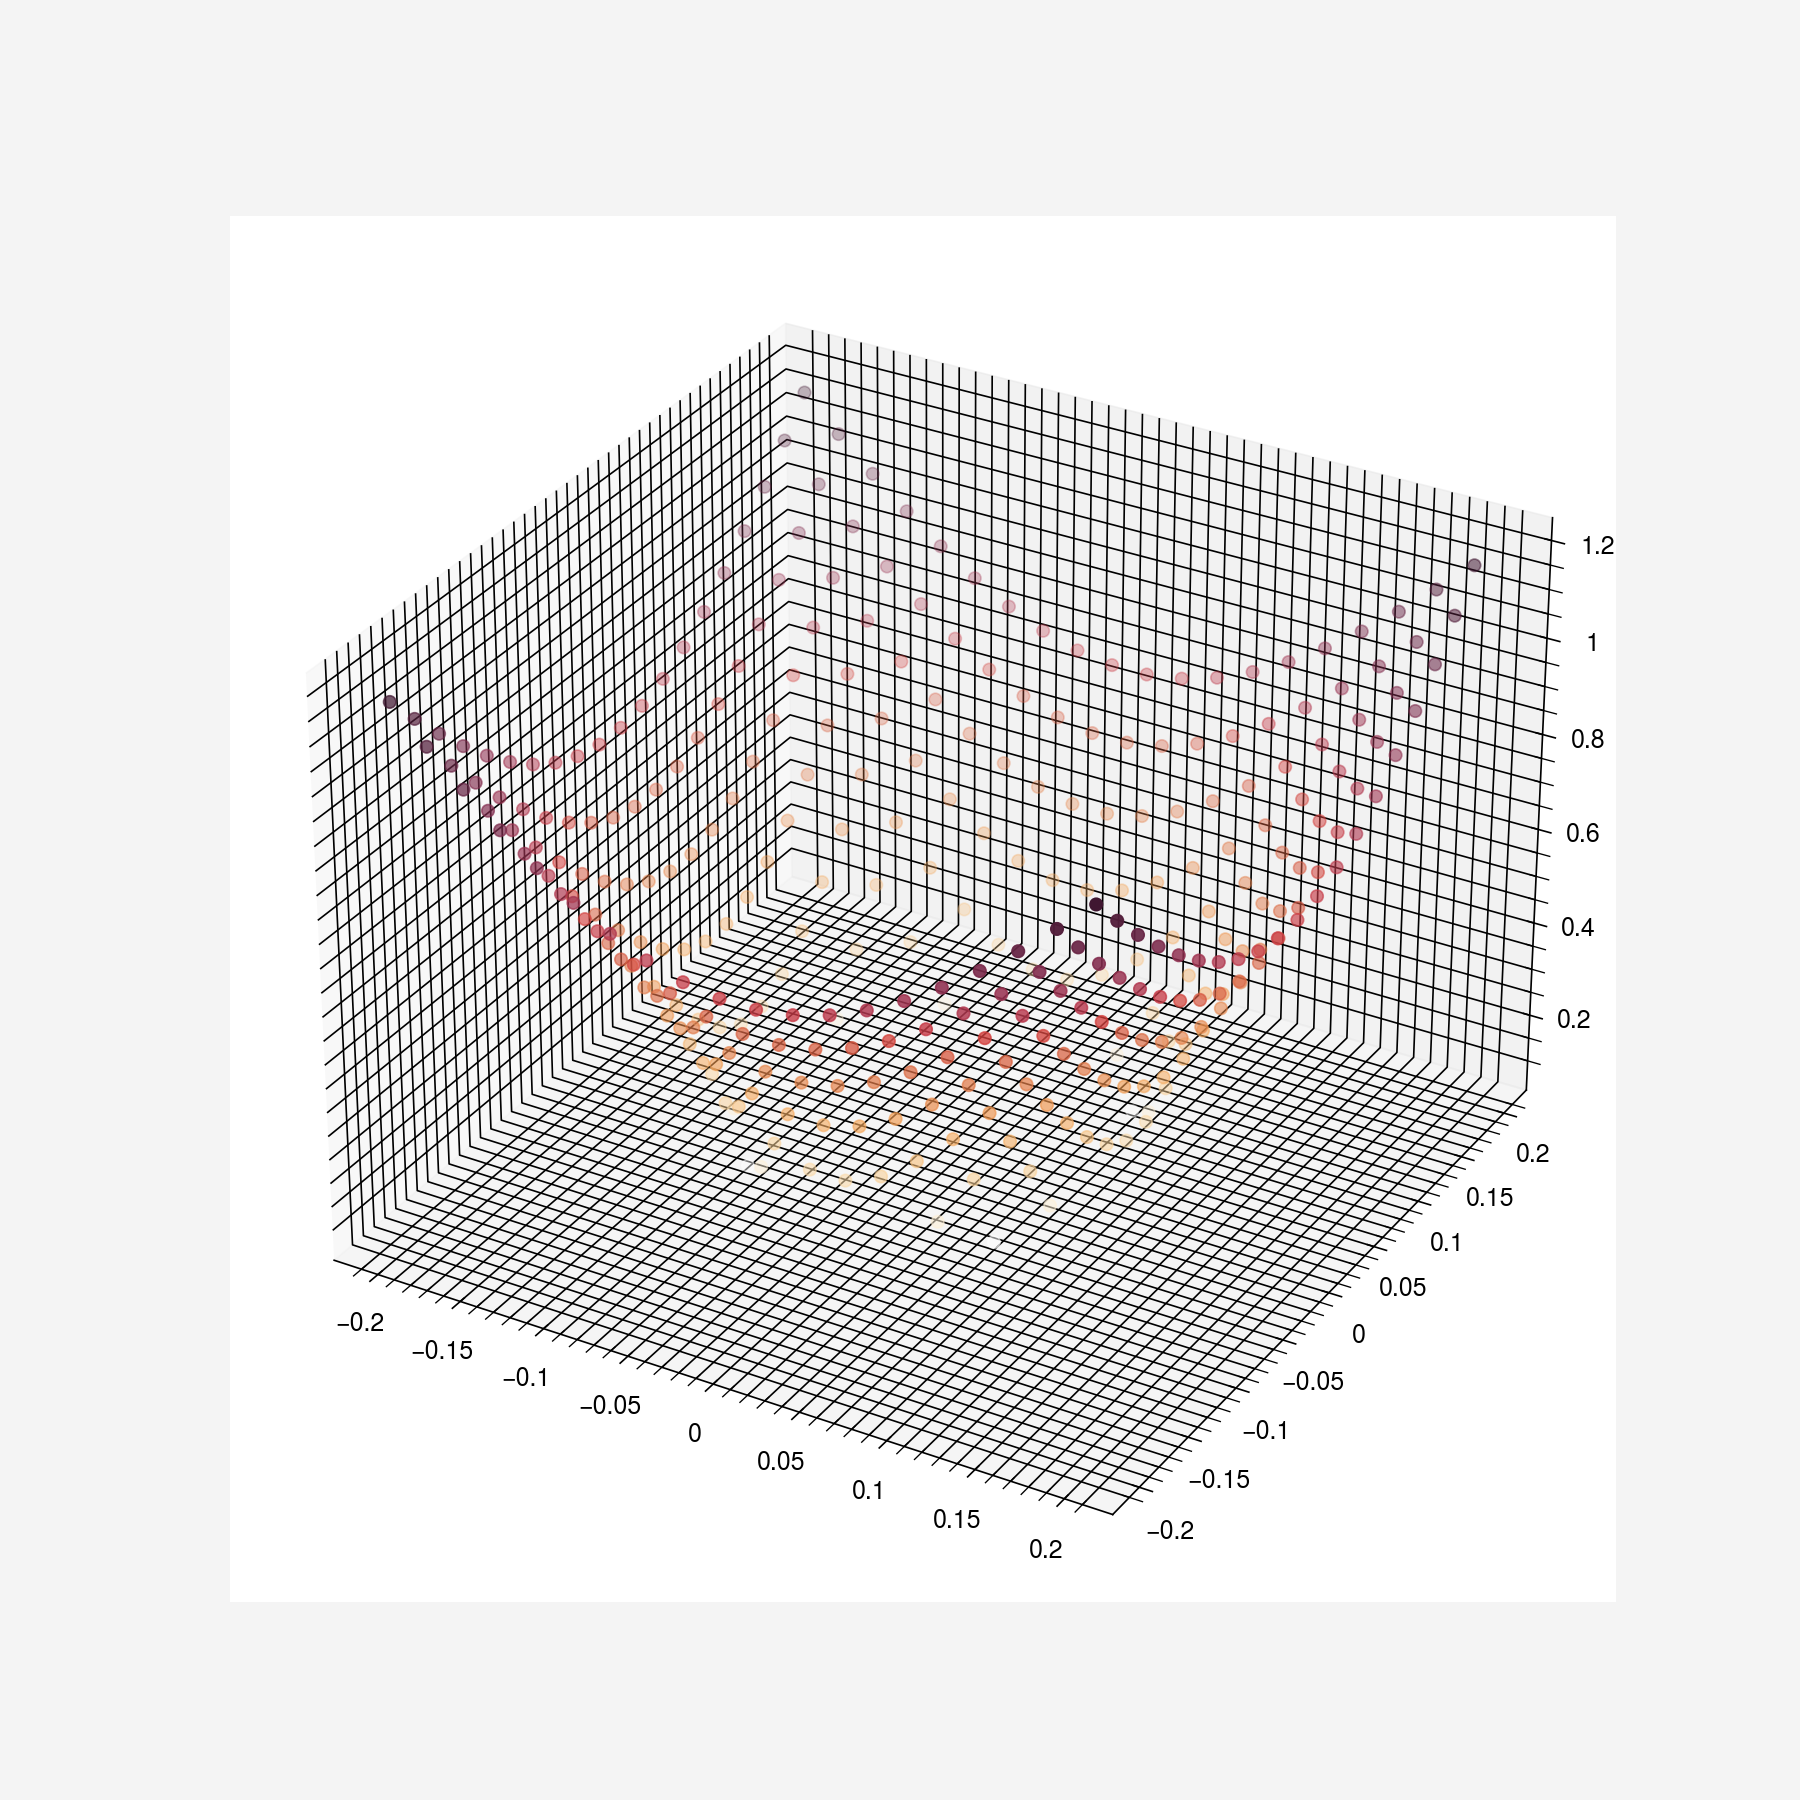

In [5]:
fig = plt.figure(figsize = [9,9])
ax = fig.add_subplot(111, projection='3d')

#ax.contourf(x_vals, y_vals, np.abs(z_vals))
ax.scatter(x_vals, y_vals, np.abs(z_vals), c=np.abs(z_vals_valid))

plt.show()

# Gradient, Hessian and curvature calculation

In [6]:
# TODO: Plot the Hessian points for 1 of the hyperboloid points
# TODO: run for smaller & smaller & check difference to analytic result
kwargs = {}
kwargs['distance'] = 2e-4
kwargs['n_points'] = 1e3
kwargs['learning_rate'] = 5e-2
kwargs['random_walk'] = False
kwargs['return_points'] = False
kwargs['progress'] = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = pytorch_hyperboloid(a, c)
model.to(device)

pytorch_hyperboloid()

In [7]:
grad_close = []
hess_close = []
hess_dist = []
n_points = 10
points = np.random.choice(range(len(valid_z_indices[0])), n_points, replace=False)
for point in points:
    x_idx = valid_z_indices[0][point]
    y_idx = valid_z_indices[1][point]
    est_outputs = numeric_pt_grad_hess(model, x_vals[x_idx, y_idx], y_vals[x_idx, y_idx], device, kwargs)
    est_pt_grad = est_outputs[0].detach().cpu().numpy()
    est_pt_hess = est_outputs[1].detach().cpu().numpy().flatten()

    autodiff_outputs = autodiff_pt_grad_hess(x_vals[x_idx, y_idx], y_vals[x_idx, y_idx], a, c, device)
    exact_pt_grad = autodiff_outputs[0].data.cpu().numpy()
    exact_pt_hess = autodiff_outputs[1].data.cpu().numpy()
    
    pt_grad_close = np.allclose(exact_pt_grad[np.logical_not(np.isnan(exact_pt_grad))], est_pt_grad[np.logical_not(np.isnan(est_pt_grad))])
    pt_hess_close = np.allclose(exact_pt_hess[np.logical_not(np.isnan(exact_pt_hess))], est_pt_hess[np.logical_not(np.isnan(est_pt_hess))])
    pt_hess_dist = np.sqrt(np.sum((est_pt_hess - exact_pt_hess)**2))
    
    grad_close.append(pt_grad_close)
    hess_close.append(pt_hess_close)
    hess_dist.append(pt_hess_dist)

print(f'Grads are close: {grad_close}')
print(f'Hessians are close: {hess_close}')
print(f'Hessian distance: {[np.round(dist, 3) for dist in hess_dist]}')
print(kwargs)

100%|██████████| 1000/1000 [00:02<00:00, 388.97it/s]

Grads are close: [True, True, True, True, True, True, True, True, True, True]
Hessians are close: [False, False, False, False, False, False, False, False, False, False]
Hessian distance: [0.752, 0.642, 0.051, 6.785, 0.005, 0.024, 0.853, 0.019, 0.004, 0.036]
{'distance': 0.0002, 'n_points': 1000.0, 'learning_rate': 0.05, 'random_walk': False, 'return_points': False, 'progress': True}


In [8]:
num_shuffles = 5
auto_rms_error = 0
numeric_rms_error = 0
for shuffle_idx in tqdm(range(num_shuffles)):
    np.random.shuffle(points)
    x_idx = valid_z_indices[0][points[0, ...]]
    y_idx = valid_z_indices[1][points[0, ...]]
    tmp_kwargs = kwargs.copy()
    tmp_kwargs['progress'] = False
    est_outputs = numeric_pt_grad_hess(model, x_vals[x_idx, y_idx], y_vals[x_idx, y_idx], device, tmp_kwargs)
    est_pt_grad = est_outputs[0]
    est_pt_hess = est_outputs[1].reshape(2, 2).double()
    autodiff_outputs = autodiff_pt_grad_hess(x_vals[x_idx, y_idx], y_vals[x_idx, y_idx], a, c, device)
    exact_pt_grad = autodiff_outputs[0]
    exact_pt_hess = autodiff_outputs[1].reshape(2, 2)
    numpy_data = []
    for point in points:
        x_idx = valid_z_indices[0][point]
        y_idx = valid_z_indices[1][point]
        x_data = x_vals[x_idx, y_idx]
        y_data = y_vals[x_idx, y_idx]
        numpy_data.append(np.stack([x_data, y_data], axis=0))
    torch_data =  torch.from_numpy(np.stack(numpy_data, axis=0)).to(device)
    f = lambda x: model_funcs.unit_activation_and_gradient(model, x, target_neuron=0)
    auto_hess_approximation = curv_funcs.hessian_approximate_response(f, torch_data, exact_pt_hess)
    numeric_hess_approximation = curv_funcs.hessian_approximate_response(f, torch_data, est_pt_hess)
    model_outputs = model_funcs.unit_activation(model, torch_data, target_neuron=0)
    auto_rms_error += torch.sqrt((auto_hess_approximation - model_outputs)**2)
    numeric_rms_error += torch.sqrt((numeric_hess_approximation - model_outputs)**2)
numeric_rms_error = numeric_rms_error / num_shuffles
auto_rms_error = auto_rms_error / num_shuffles

print(f'numeric estimation method RMS error = {numeric_rms_error.mean():.4f}')
print(f'autodiff method RMS error = {auto_rms_error.mean():.4f}')

100%|██████████| 5/5 [00:12<00:00,  2.50s/it]

numeric estimation method RMS error = 7.9697
autodiff method RMS error = 7.9615


In [9]:
kwargs['progress'] = False
numeric_grad, numeric_hess = numeric_grad_hess(model, x_vals, y_vals, device, kwargs) # about 1k points / min on a gpu
np_numeric_grad = numeric_grad.detach().cpu().numpy().copy()
np_numeric_hess = numeric_hess.detach().cpu().numpy().copy()

100%|██████████| 20/20 [16:15<00:00, 48.80s/it]


In [10]:
numeric_gauss_curvature, numeric_mean_curvature = curvature_points(numeric_grad, numeric_hess, device)

In [11]:
autodiff_grad, autodiff_hess = autodiff_grad_hess(x_vals, y_vals, a, c, device)
autodiff_gauss_curvature, autodiff_mean_curvature = curvature_points(autodiff_grad, autodiff_hess, device)
np_autodiff_grad = autodiff_grad.detach().cpu().numpy()
np_autodiff_hess = autodiff_hess.detach().cpu().numpy()

100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


# Compare methods

In [12]:
autodiff_grad_valid = np_autodiff_grad[np.logical_not(np.isnan(np_autodiff_grad))]
numeric_grad_valid = np_numeric_grad[np.logical_not(np.isnan(np_numeric_grad))]
autodiff_hess_valid = np_autodiff_hess[np.logical_not(np.isnan(np_autodiff_hess))]
numeric_hess_valid = np_numeric_hess[np.logical_not(np.isnan(np_numeric_hess))]
grads_close = np.allclose(autodiff_grad_valid, numeric_grad_valid)
print(f'Grads are close: {grads_close}')

Grads are close: True


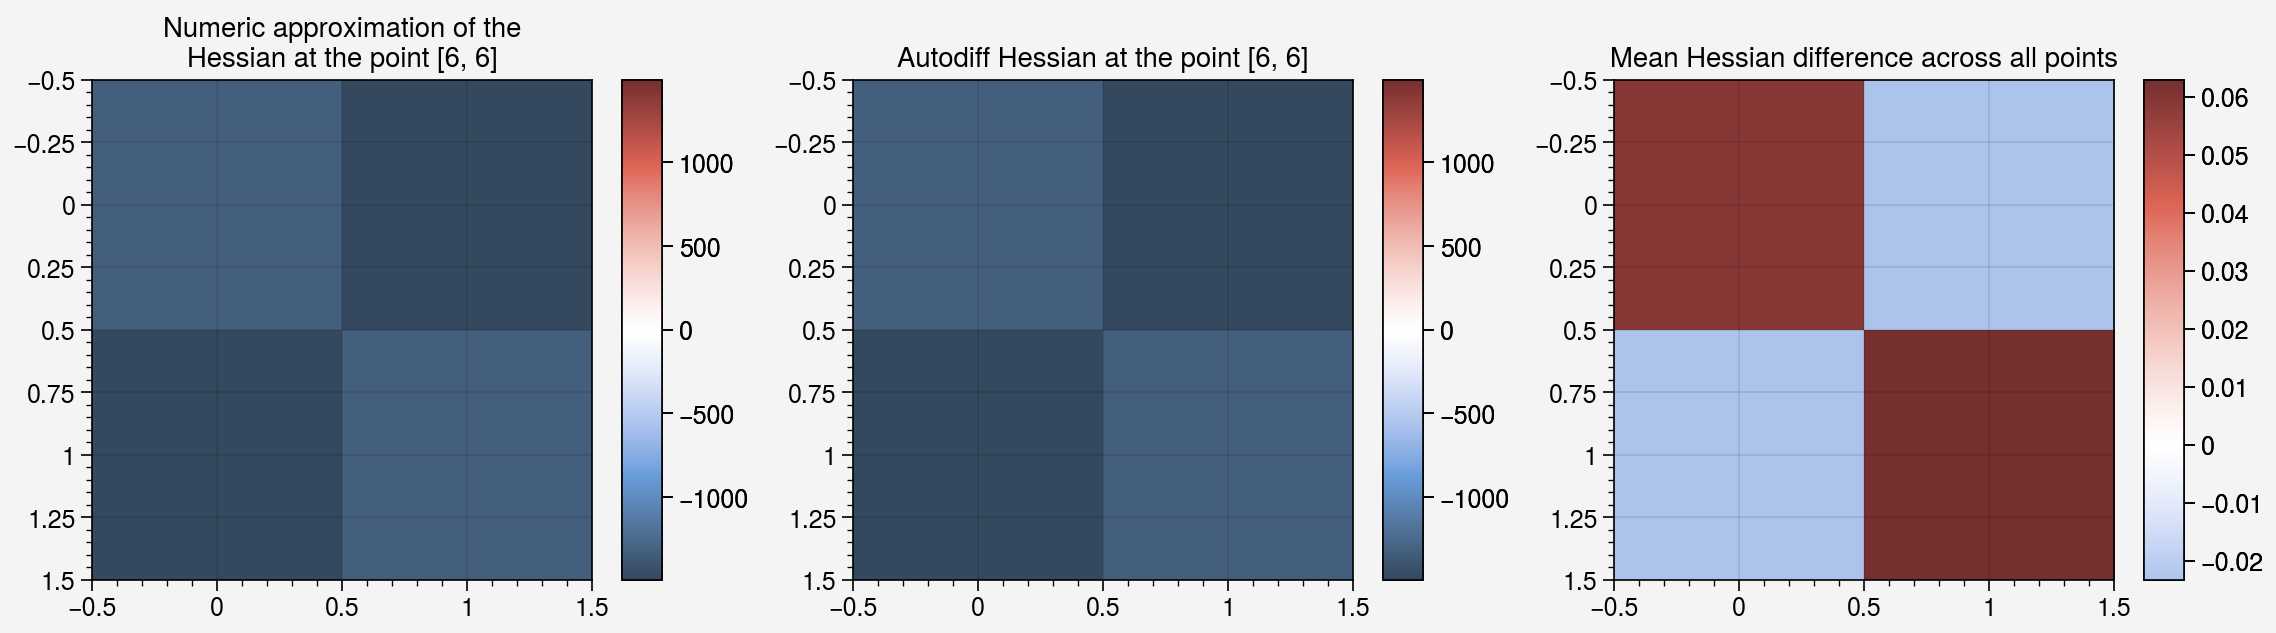

In [13]:
ptx = num_points//3; pty = num_points//3

vmin = np.min([np.min(autodiff_hess_valid), np.min(numeric_hess_valid)])
vmax = np.max([np.max(autodiff_hess_valid), np.max(numeric_hess_valid)])
hess_diff = np_autodiff_hess - np_numeric_hess
hess_diff[np.isnan(hess_diff)] = 0
mean_hess_diff = np.mean(hess_diff, axis=(0,1)).reshape(2,2)

fig, axs = plot.subplots(nrows=1, ncols=3, sharex=False,  sharey=False)
mappable = axs[0].imshow(np_numeric_hess[ptx, pty, :].reshape(2,2), vmin=vmin, vmax=vmax)
axs[0].colorbar(mappable)
axs[0].format(title=f"Numeric approximation of the\nHessian at the point [{ptx}, {pty}]")
mappable = axs[1].imshow(np_autodiff_hess[ptx, pty, :].reshape(2,2), vmin=vmin, vmax=vmax)
axs[1].colorbar(mappable)
axs[1].format(title=f"Autodiff Hessian at the point [{ptx}, {pty}]")
mappable = axs[2].imshow(mean_hess_diff)
axs[2].colorbar(mappable)
axs[2].format(title='Mean Hessian difference across all points')
plot.show()

# Analytic Gaussian curvature

In [14]:
u = z_vals / c

analytic_gauss_curvature = -c**2 / (c**2 + (a**2 + c**2) * u**2)**2

analytic_mean_curvature_numerator = c**2 * (a**2 * (u**2 - 1) + c**2 * (u**2 + 1))
analytic_mean_curvature_denominator = 2 * a * (c**2 + (a**2 + c**2) * u**2)**(3/2)
analytic_mean_curvature = analytic_mean_curvature_numerator / analytic_mean_curvature_denominator

sqrt_term = np.sqrt(c**2 + (a**2 + c**2) * u**2)
sf_d1 = - (a * c) / ((1 + u**2) * sqrt_term)
sf_d2 = (a * c * (1 + u**2)) / sqrt_term
analytic_sf_diagonal = np.stack([sf_d1, sf_d2], axis=0)

A number of points near the origin have an imaginary z value and are given curvature = 0:

In [15]:
print(f"Number of autodiff points with 0 Gaussian curvature = {sum(autodiff_gauss_curvature.flatten()==0)}")
print(f"Number of numeric estimated points with 0 Gaussian curvature = {sum(numeric_gauss_curvature.flatten()==0)}")
print(f"Number of analytic points with 0 Gaussian curvature = {sum(analytic_gauss_curvature.flatten()==0)}")

Number of autodiff points with 0 Gaussian curvature = 76
Number of numeric estimated points with 0 Gaussian curvature = 76
Number of analytic points with 0 Gaussian curvature = 0


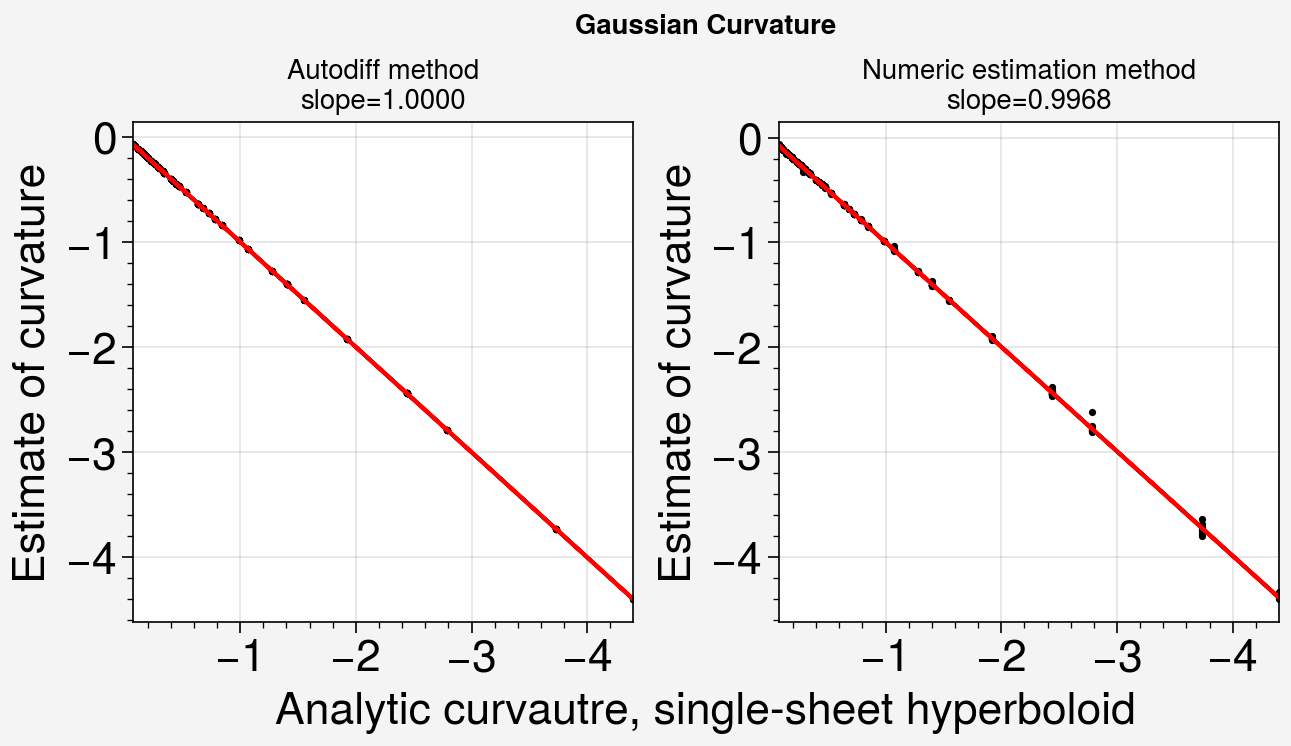

In [16]:
fig, axs = plot.subplots(nrows=1, ncols=2, sharey=False)
axs[0].scatter(analytic_gauss_curvature.flatten(), autodiff_gauss_curvature.flatten(), s=4, c='k')
valid_analytic = analytic_gauss_curvature.flatten()[np.logical_not(np.isnan(analytic_gauss_curvature.flatten()))]
valid_computed = autodiff_gauss_curvature.flatten()[np.logical_not(np.isnan(analytic_gauss_curvature.flatten()))]
slope, intercept = np.polyfit(valid_analytic, valid_computed, 1)
predicted_ys = [slope * curvature + intercept for curvature in valid_analytic]
axs[0].plot(valid_analytic, predicted_ys, 'r')
axs[0].format(
    title = f"Autodiff method\nslope={slope:.4f}",
    xlabel = 'Analytic curvautre, single-sheet hyperboloid',
    ylabel = 'Estimate of curvature',
    fontsize = 16,
)

axs[1].scatter(analytic_gauss_curvature.flatten(), numeric_gauss_curvature.flatten(), s=4, c='k')
valid_computed = numeric_gauss_curvature.flatten()[np.logical_not(np.isnan(analytic_gauss_curvature.flatten()))]
slope, intercept = np.polyfit(valid_analytic, valid_computed, 1)
predicted_ys = [slope * curvature + intercept for curvature in valid_analytic]
axs[1].plot(valid_analytic, predicted_ys, 'r')
axs[1].format(
    title = f'Numeric estimation method\nslope={slope:.4f}',
    xlabel = 'Analytic curvautre, single-sheet hyperboloid',
    ylabel = 'Estimate of curvature',
    fontsize = 16,
)
axs.format(suptitle='Gaussian Curvature')
plot.show()

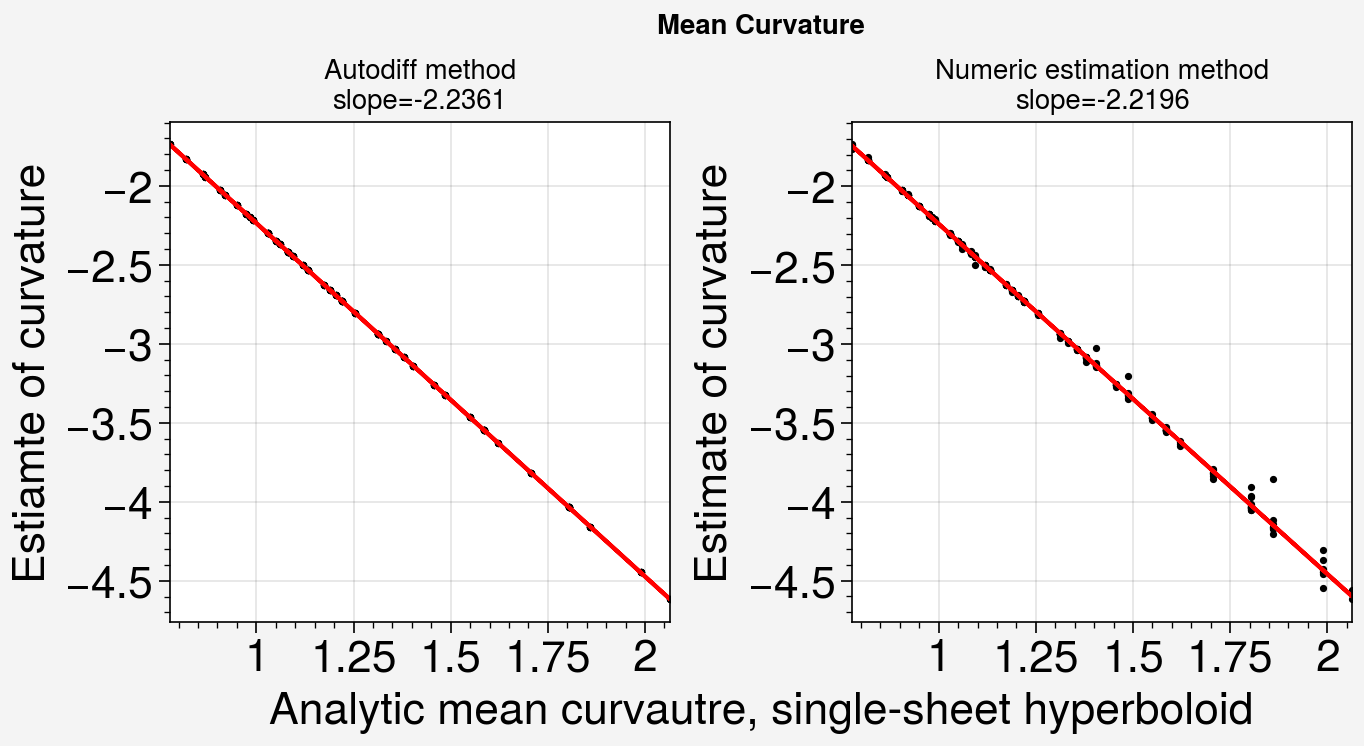

In [17]:
fig, axs = plot.subplots(nrows=1, ncols=2, sharey=False)

axs[0].scatter(analytic_mean_curvature.flatten(), autodiff_mean_curvature.flatten(), s=4, c='k')
valid_analytic = analytic_mean_curvature.flatten()[np.logical_not(np.isnan(analytic_mean_curvature.flatten()))]
valid_computed = autodiff_mean_curvature.flatten()[np.logical_not(np.isnan(analytic_mean_curvature.flatten()))]
slope, intercept = np.polyfit(valid_analytic, valid_computed, 1)
predicted_ys = [slope * curvature + intercept for curvature in valid_analytic]
axs[0].plot(valid_analytic, predicted_ys, 'r')
axs[0].format(
    title = f'Autodiff method\nslope={slope:.4f}',
    xlabel = 'Analytic mean curvautre, single-sheet hyperboloid',
    ylabel = 'Estiamte of curvature',
    fontsize = 16,
)

axs[1].scatter(analytic_mean_curvature.flatten(), numeric_mean_curvature.flatten(), s=4, c='k')
valid_computed = numeric_mean_curvature.flatten()[np.logical_not(np.isnan(analytic_mean_curvature.flatten()))]
slope, intercept = np.polyfit(valid_analytic, valid_computed, 1)
predicted_ys = [slope * curvature + intercept for curvature in valid_analytic]
axs[1].plot(valid_analytic, predicted_ys, 'r')
axs[1].format(
    title = f'Numeric estimation method\nslope={slope:.4f}',
    xlabel = 'Analytic mean curvautre, single-sheet hyperboloid',
    ylabel = 'Estimate of curvature',
    fontsize = 16,
)
axs.format(suptitle='Mean Curvature')
plot.show()

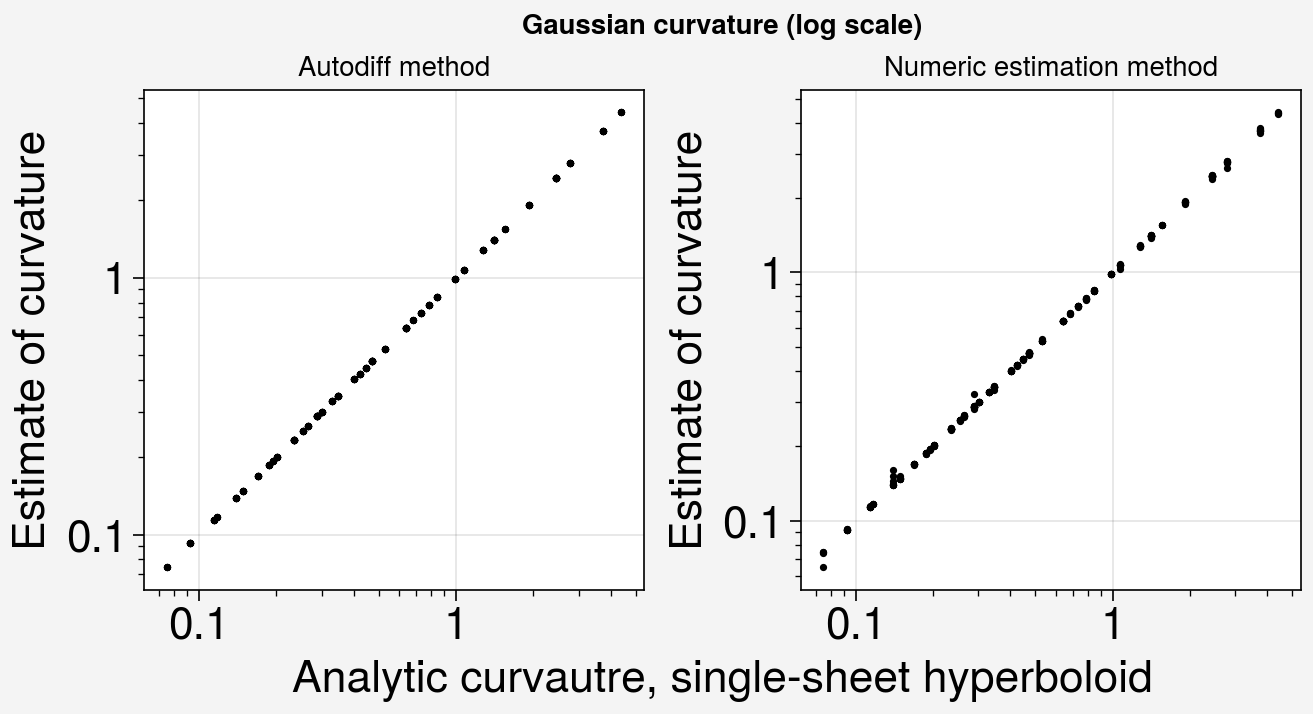

In [18]:
fig, axs = plot.subplots(nrows=1, ncols=2, sharey=False)
axs[0].scatter(np.abs(analytic_gauss_curvature.flatten()), np.abs(autodiff_gauss_curvature.flatten()), s=4, c='k')
axs[0].format(
    title = 'Autodiff method',
    xlabel = 'Analytic curvautre, single-sheet hyperboloid',
    ylabel = 'Estimate of curvature',
    fontsize = 16,
    yscale = 'log',
    xscale = 'log'
)

axs[1].scatter(np.abs(analytic_gauss_curvature.flatten()), np.abs(numeric_gauss_curvature.flatten()), s=4, c='k')
axs[1].format(
    title = 'Numeric estimation method',
    xlabel = 'Analytic curvautre, single-sheet hyperboloid',
    ylabel = 'Estimate of curvature',
    fontsize = 16,
    yscale = 'log',
    xscale = 'log'
)

axs.format(suptitle='Gaussian curvature (log scale)')
#axs.set_aspect('equal')
plot.show()

In [19]:
autodiff_largest_deviation = np.max(np.abs((analytic_gauss_curvature[np.logical_not(np.isnan(np_autodiff_grad[:,:,0]))].flatten() - autodiff_gauss_curvature[np.logical_not(np.isnan(np_autodiff_grad[:,:,0]))].flatten())))
numeric_largest_deviation = np.max(np.abs((analytic_gauss_curvature[np.logical_not(np.isnan(np_numeric_grad[:,:,0]))].flatten() - numeric_gauss_curvature[np.logical_not(np.isnan(np_numeric_grad[:,:,0]))].flatten())))
print(f'Largest deviation from the analytic result for autodiff method (Gaussian): {autodiff_largest_deviation}')
print(f'Largest deviation from the analytic result for numeric estimation method (Gaussian): {numeric_largest_deviation}')

autodiff_largest_deviation = np.max(np.abs((analytic_mean_curvature[np.logical_not(np.isnan(np_autodiff_grad[:,:,0]))].flatten() - autodiff_mean_curvature[np.logical_not(np.isnan(np_autodiff_grad[:,:,0]))].flatten())))
numeric_largest_deviation = np.max(np.abs((analytic_mean_curvature[np.logical_not(np.isnan(np_numeric_grad[:,:,0]))].flatten() - numeric_mean_curvature[np.logical_not(np.isnan(np_numeric_grad[:,:,0]))].flatten())))
print(f"\nLargest deviation from the analytic result for James' method (Mean): {autodiff_largest_deviation}")
print(f"Largest deviation from the analytic result for Dylan's method (Mean): {numeric_largest_deviation}")

Largest deviation from the analytic result for autodiff method (Gaussian): 1.3071086110372221e-05
Largest deviation from the analytic result for numeric estimation method (Gaussian): 0.1643724546876144

Largest deviation from the analytic result for James' method (Mean): 6.678229352079574
Largest deviation from the analytic result for Dylan's method (Mean): 6.6801805697309415


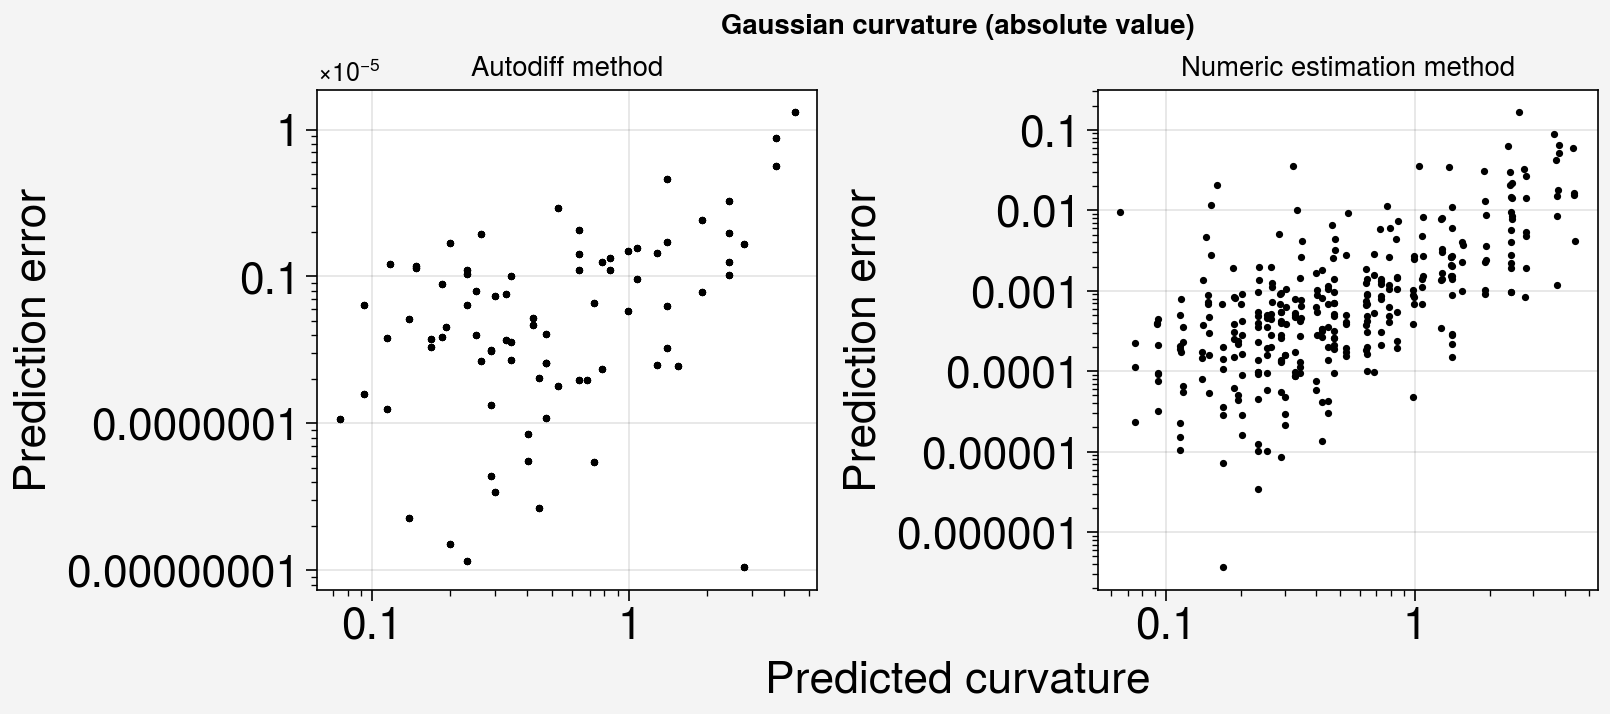

In [20]:
fig, axs = plot.subplots(nrows=1, ncols=2, sharey=False)

axs[0].scatter(np.abs(autodiff_gauss_curvature.flatten()),
               np.abs(analytic_gauss_curvature.flatten() - autodiff_gauss_curvature.flatten()),
               s=4, c='k')
axs[0].format(
    title = 'Autodiff method',
    xlabel = 'Predicted curvature',
    ylabel = 'Prediction error',
    fontsize = 16,
    yscale = 'log',
    xscale = 'log',
    #ylim = [1e-18, 1e-12]
)
axs[1].scatter(np.abs(numeric_gauss_curvature.flatten()),
               np.abs(analytic_gauss_curvature.flatten() - numeric_gauss_curvature.flatten()),
               s=4, c='k')
axs[1].format(
    title = 'Numeric estimation method',
    xlabel = 'Predicted curvature',
    ylabel = 'Prediction error',
    fontsize = 16,
    yscale = 'log',
    xscale = 'log',
    #ylim = [1e-18, 1e-12]
)
axs.format(suptitle='Gaussian curvature (absolute value)')
plot.show()

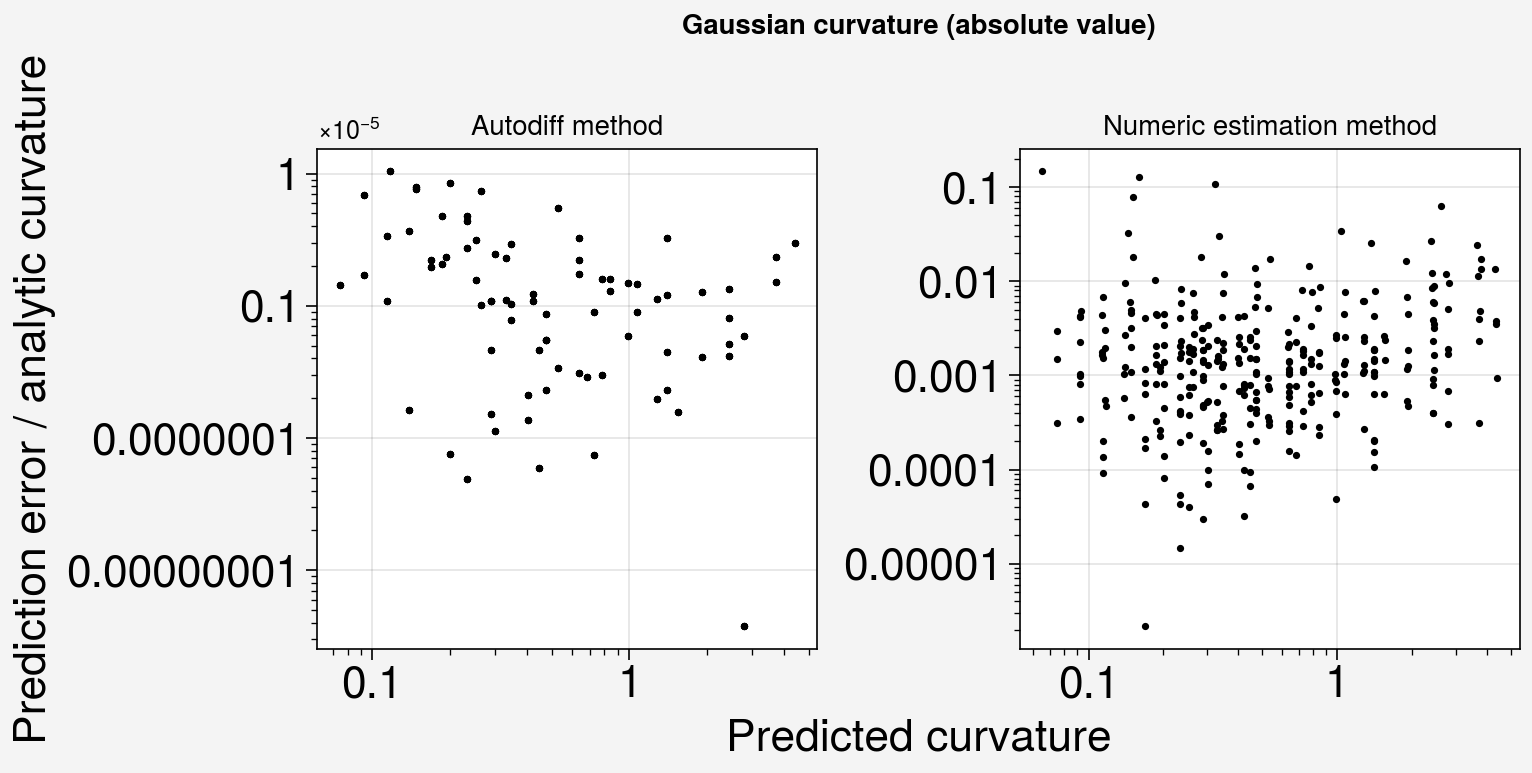

In [21]:
fig, axs = plot.subplots(nrows=1, ncols=2, sharey=False)

axs[0].scatter(np.abs(autodiff_gauss_curvature.flatten()),
    np.abs(analytic_gauss_curvature.flatten() - autodiff_gauss_curvature.flatten()) / np.abs(autodiff_gauss_curvature.flatten()),
    s=4, c='k')
axs[0].format(
    title = 'Autodiff method',
    xlabel = 'Predicted curvature',
    ylabel = 'Prediction error / analytic curvature',
    fontsize = 16,
    yscale = 'log',
    xscale = 'log',
    #ylim = [1e-16, 1e-12]
)
axs[1].scatter(np.abs(numeric_gauss_curvature.flatten()),
    np.abs(analytic_gauss_curvature.flatten() - numeric_gauss_curvature.flatten()) / np.abs(numeric_gauss_curvature.flatten()),
    s=4, c='k')
axs[1].format(
    title = 'Numeric estimation method',
    xlabel = 'Predicted curvature',
    fontsize = 16,
    yscale = 'log',
    xscale = 'log',
    #ylim = [1e-16, 1e-12]
)
axs.format(suptitle='Gaussian curvature (absolute value)')
plot.show()

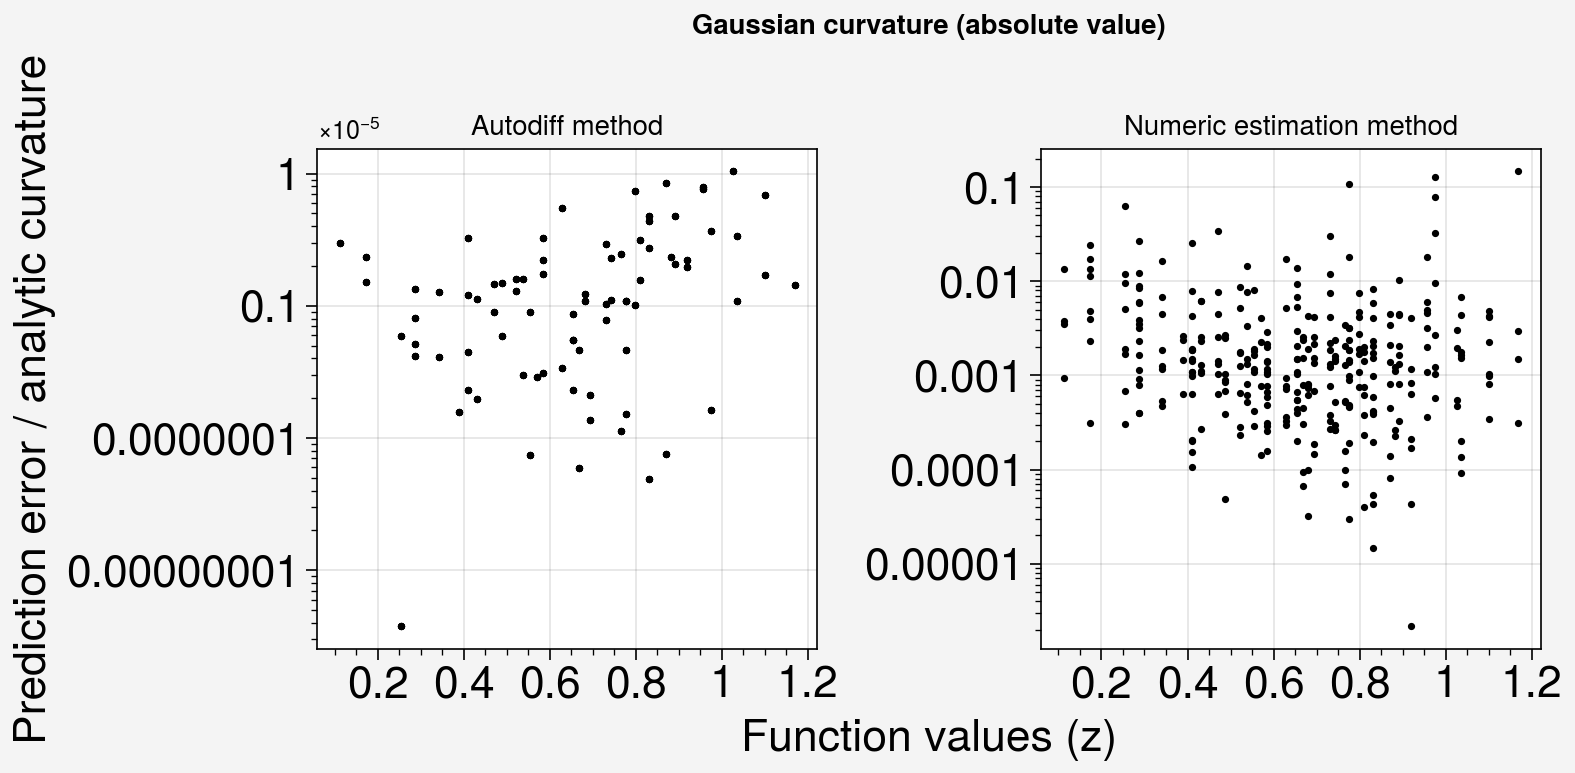

In [22]:
fig, axs = plot.subplots(nrows=1, ncols=2, sharey=False)

axs[0].scatter(z_vals.flatten(),
    np.abs(analytic_gauss_curvature.flatten() - autodiff_gauss_curvature.flatten()) / np.abs(autodiff_gauss_curvature.flatten()),
    s=4, c='k')
axs[0].format(
    title = 'Autodiff method',
    xlabel = 'Function values (z)',
    ylabel = 'Prediction error / analytic curvature',
    fontsize = 16,
    yscale = 'log',
    #ylim = [1e-16, 1e-12]
)
axs[1].scatter(z_vals.flatten(),
    np.abs(analytic_gauss_curvature.flatten() - numeric_gauss_curvature.flatten()) / np.abs(numeric_gauss_curvature.flatten()),
    s=4, c='k')
axs[1].format(
    title = 'Numeric estimation method',
    xlabel = 'Function values (z)',
    fontsize = 16,
    yscale = 'log',
    #ylim = [1e-16, 1e-12]
)
axs.format(suptitle='Gaussian curvature (absolute value)')
plot.show()

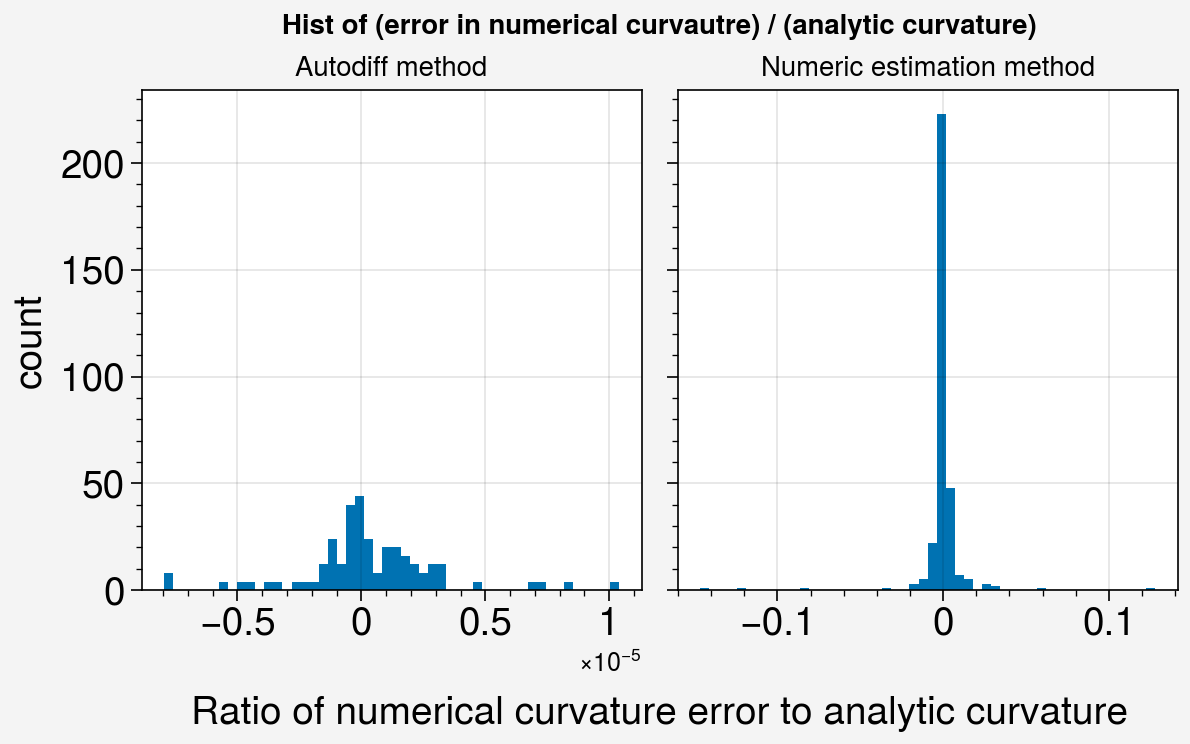

In [23]:
fig, axs = plot.subplots(nrows=1, ncols=2)
autodiff_error = analytic_gauss_curvature.flatten() - autodiff_gauss_curvature.flatten()
autodiff_error_norm = autodiff_error / analytic_gauss_curvature.flatten()
axs[0].hist(autodiff_error_norm, bins=50)
axs[0].format(
    title = 'Autodiff method',
    ylabel = 'count',
    fontsize = 14
)
numeric_error = analytic_gauss_curvature.flatten() - numeric_gauss_curvature.flatten()
numeric_error_norm = numeric_error / analytic_gauss_curvature.flatten()
axs[1].hist(numeric_error_norm, bins=50)
axs[1].format(
    title = 'Numeric estimation method',
    ylabel = 'count',
    fontsize = 14
)
axs.format(
    suptitle = 'Hist of (error in numerical curvautre) / (analytic curvature)',
    xlabel = '\nRatio of numerical curvature error to analytic curvature',
)
plot.show()